In [81]:
# import memory_profiler
import psutil as psu

In [83]:
psutil.cpu_percent()

26.5

In [ ]:
# Python version check
import sys
!{sys.executable} --version

In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

전처리 상에서의 이슈, 처리할 사항
- int64를 int32로 변환
- 날짜 컬럼을 파싱하는 과정에서 object -> int32 -> string -> datetime 의 단계를 거침. 더 효율적인 방법은?
- float을 int로 변환할 수 없다는 에러 발생시 어떻게? "Warning: cannot convert non-finite"
- object 컬럼을 integer로 변환할 때 예외처리: `pd.to_numeric` 이후 `.dropna` 말고 `.fillna(999)` 등을 이용
- lambda apply 함수는 언제 효율적인가?
데이터 로드, 병합, 저장시 이슈 & 처리할 사항
- `pd.read_csv()` 할 때 key 값 지정?
- `join`할 때 key가 되는 두 컬럼의 dtype이 다르면 조인되지 않는다
- `join`을 3개 이상 할 수 있는지?

행 or 열 삭제, 변경할 때 이슈 & 처리사항
- 이름이 없는 컬럼 삭제
- 컬럼명 변경 or 지정
- index가 없는 컬럼 로드시 계속 unnamed:0, unnamed: 1 컬럼 등이 자동 생성됨
- 특정 조건에 맞는 컬럼 검색시, int is unslicable 에러
- 특정 행 삭제는 어떻게?

### Data Extraction 

In [48]:
# make sample

num_txn = 1000000 # 1/100 of real data 
num_cus = 40000 # 1/100 of real data
num_mct = 100

In [59]:
array01old = np.random.randint(0, num_cus, size=(num_txn, 1) ) # CLNN

array01a = np.random.randn(num_txn, 1)
array01 = np.round(np.sqrt(np.square(array01a)) * 10000)
max(array01)

array([52504.])

In [62]:
array02 = np.random.randint(180701, 180731, size=(num_txn, 1)) # TS_D # 승인날짜

In [63]:
# times = pd.date_range('2018-07-01', periods=31, freq='1440min')
# array02new = np.random.choice(times, size=num_txn, replace=True, p=None) # TS_D # 승인날짜
# array02new

In [64]:
array03 = np.random.randint(0, 100, size=(num_txn, 1)) # FINAL_CD # 업종코드 

In [65]:
array04a = np.random.randn(num_txn, 1) # SAA # 승인금액
array04 = np.round(np.sqrt(np.square(array04a)) * 20 + 3) 

In [66]:
# array05old = np.random.randint(0, 424, size=(num_txn, 1)) 

array05a = np.random.randn(num_txn, 1) # MCT_ADM_GDS_APB_CD # 서울 행정동 코드
array05 = np.round(np.sqrt(np.square(array05a)) * 30)

In [8]:
# array06a = np.random.randint(1, 2, size=(round(num_txn*5/7), 1)) # DOF_TF # 평일 or 휴일
# array06b = np.random.randint(0, 1, size=(round(num_txn*2/7), 1)) # DOF_TF # 평일 or 휴일
# array06 = np.append(array06a, array06b, axis=0)
# random.shuffle(array06)

In [67]:
# 더 간편한 방법
array06 = np.random.choice(2, size=num_txn, p=[5/7, 2/7]) # 2 미만의 정수 중 p의 확률로 랜덤 선택

In [68]:
array07 = np.random.randint(0, 6, size=(num_txn, 1)) # DAW_CCD # 요일코드 # array06과 맞추기 어려워서 임시로 랜덤

In [69]:
array08 = np.random.randint(0, num_mct, size=(num_txn, 1)) # MCT_N # 가맹점 번호

In [70]:
array09 = np.random.randint(1, 240000, size=(num_txn, 1)) # TIME # 24h 시간 # 정확히 맞는 숫자는 아님

In [71]:
df = pd.DataFrame( np.column_stack([array01, array02, array03, array04, array05, array06, array07, array08, array09])
                  , columns = ['CLNN', 'TS_D', 'FINAL_CD', 'SAA', 'MCT_ADM_GDS_APB_CD', 'DOF_TF', 'DAW_CCD', 'MCT_N', 'TIME'])

In [72]:
df['CLNN'] = df['CLNN'].astype(int)
df['TS_D'] = df['TS_D'].astype(int)
df['TS_D'] = pd.to_datetime(df['TS_D'], format='%y%m%d') # %Y는 4글자 연도 
df['FINAL_CD'] = df['FINAL_CD'].astype(int)
df['SAA'] = df['SAA'].astype(int)
df['MCT_ADM_GDS_APB_CD'] = df['MCT_ADM_GDS_APB_CD'].astype(int)
df['DOF_TF'] = df['DOF_TF'].astype(int)
df['DAW_CCD'] = df['DAW_CCD'].astype(int)
df['MCT_N'] = df['MCT_N'].astype(int)
df['TIME'] = df['TIME'].astype(int)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
CLNN                  1000000 non-null int64
TS_D                  1000000 non-null datetime64[ns]
FINAL_CD              1000000 non-null int64
SAA                   1000000 non-null int64
MCT_ADM_GDS_APB_CD    1000000 non-null int64
DOF_TF                1000000 non-null int64
DAW_CCD               1000000 non-null int64
MCT_N                 1000000 non-null int64
TIME                  1000000 non-null int64
dtypes: datetime64[ns](1), int64(8)
memory usage: 68.7 MB


### File Save

In [73]:
df.to_csv('df.csv')

In [52]:
start_time = time.time()

print("%d transactions --- %.2f seconds ---"%(len(df), time.time() - start_time))

1000000 transactions --- 0.00 seconds ---


### Data Load

In [5]:
df = pd.read_csv('df.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
Unnamed: 0            1000000 non-null int64
CLNN                  1000000 non-null int64
TS_D                  1000000 non-null object
FINAL_CD              1000000 non-null int64
SAA                   1000000 non-null int64
MCT_ADM_GDS_APB_CD    1000000 non-null int64
DOF_TF                1000000 non-null int64
DAW_CCD               1000000 non-null int64
MCT_N                 1000000 non-null int64
TIME                  1000000 non-null int64
dtypes: int64(9), object(1)
memory usage: 76.3+ MB


### Data Merge 

In [18]:
df3 = df.append(df2, ignore_index=True)

In [ ]:
trx07_08_09_df = trx07_08_df.append(trx09_df, ignore_index=True, sort=True) #sort=

### GroupBy 객체 만들기

In [74]:
groupedByCLNN = df.groupby('CLNN')

In [27]:
# 주의 
groupedByCLNN.describe()['SAA'].head() # 계산시 오래걸림

In [85]:
cntSAAgbCLNN = groupedByCLNN.count()['TIME'].head(15) # Count 를 trxid가 아닌 다른 값 기준으로 하면 identify 안될 수도 있다...
cntSAAgbCLNN

CLNN
0     41
1     78
2     77
3     86
4     76
5     83
6     87
7     70
8     75
9     79
10    85
11    60
12    89
13    91
14    69
Name: TIME, dtype: int64

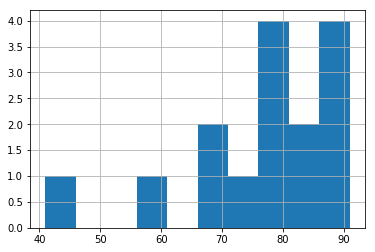

In [79]:
cntSAAgbCLNN.hist()

In [83]:
sumSAAgbCLNN = groupedByCLNN.sum()['SAA'].head(10)
sumSAAgbCLNN

CLNN
0     684
1    1525
2    1505
3    1830
4    1514
5    1569
6    1909
7    1195
8    1410
9    1449
Name: SAA, dtype: int64

In [84]:
groupedByCLNN.mean()['SAA'].head(10)

CLNN
0    16.682927
1    19.551282
2    19.545455
3    21.279070
4    19.921053
5    18.903614
6    21.942529
7    17.071429
8    18.800000
9    18.341772
Name: SAA, dtype: float64

In [86]:
# 2개 기준으로 Group By 하기 (방법 1)
gb = df.groupby(['CLNN', 'MCT_ADM_GDS_APB_CD']) # 고객별 & 행정동별
gb2 = gb.sum()['SAA'] # 금액 합
gb2.shape[0]

648526

In [87]:
# 2개 기준으로 Group By 하기 (방법 2)
df_agg = df.groupby(['CLNN', 'MCT_ADM_GDS_APB_CD']).agg({'SAA':sum}) # 결과물은 DataFrame으로
df_agg.shape[0]

648526

In [98]:
df_agg.to_csv('df_agg.csv')

In [35]:
## GroupBy 이후의 값으로 sorting 하기

In [34]:
# NOT WORKING
df_agg = df.groupby(['CLNN', 'MCT_ADM_GDS_APB_CD']).agg({'SAA':sum})
g = df_agg['SAA'].groupby(level=0, group_keys=False)
res = g.apply(lambda x: x.order(ascending=False) ) 

In [88]:
# 헷갈리지 말것 # SAA 빼고 의미있는 값은 없음 # 더했기 때문에 여기서 CLNN도 더한 값
# Don't look at other columns, only SAA (because it is summed)
df_new = df.groupby(['CLNN']).apply(lambda x: (x.groupby('MCT_ADM_GDS_APB_CD').sum() \
                                               .sort_values('SAA', ascending=False)) \
                                    .head(3)) # top 3 sum(SAA), grouped by CLNN and MCT_ADM_GDS_APB_CD
df_new.shape[0]

85288

In [103]:
df_new.to_csv('df_new.csv')
df_new['SAA'].to_csv('df_new_SAA.csv') # 헷갈리지 말것 # SAA 빼고 의미있는 값은 없음 # 더했기 때문에 여기서 CLNN도 더한 값

In [90]:
# # Top 3 sorted order ...
# df.groupby(['CLNN', 'MCT_ADM_GDS_APB_CD'])['SAA'].nlargest(3) # --> sorting이 인덱스 기준 

In [104]:
# df.groupby(["CLNN"]).apply(lambda x: x.sort_values(["SAA"], ascending = False)).reset_index(drop=True) 
# # trx 단위이고 행정동 별로 groupby 되지 않았다는 문제

In [91]:
# # multiple groupby # NOT Right
# df.groupby(["CLNN", "MCT_ADM_GDS_APB_CD"]).apply(lambda x: x.sort_values(["SAA"], ascending = False)).reset_index(drop=True) 

In [107]:
# 다른 방법
df_gb = df.groupby('CLNN', as_index=False, sort=False) \
           .apply(lambda x: x.nlargest(1, ['SAA'])) \
           .reset_index(level=1, drop=True)
df_gb.shape[0]

31190

In [ ]:
# 다른 방법 multiple # nlargest=1

df_gb_multiptle = df.groupby(['CLNN', 'MCT_ADM_GDS_APB_CD'], as_index=False, sort=False) \
           .apply(lambda x: x.nlargest(1, ['SAA'])) \
           .reset_index(level=1, drop=True)

In [112]:
df_gb_multiptle.shape[0]


648526

In [113]:
df_gb_multiptle.head(5) # index가 섞임

,CLNN,TS_D,FINAL_CD,SAA,MCT_ADM_GDS_APB_CD,DOF_TF,DAW_CCD,MCT_N,TIME
0,14437,2018-07-19,25,11,26,0,5,36,199982
1,2414,2018-07-13,2,11,35,1,1,61,84354
2,2136,2018-07-04,20,16,2,0,1,1,21116
3,15588,2018-07-13,72,16,21,1,1,60,156460
4,6377,2018-07-28,37,14,31,0,2,58,2430


In [118]:
# 또 다른 방법 - 기준 1개
df_another = df.groupby('CLNN', group_keys=False, sort=False) \
            .apply(pd.DataFrame.nlargest, n=1, columns='SAA')
df_another.shape[0]

In [115]:
# 또 다른 방법 - multiple
df_another_multi = df.groupby(['CLNN', 'MCT_ADM_GDS_APB_CD'], group_keys=False, sort=False) \
           .apply(pd.DataFrame.nlargest, n=1, columns='SAA')
df_another_multi.shape[0]

648526

In [116]:
df_another_multi.head(5) # index가 preserve 됨 

,CLNN,TS_D,FINAL_CD,SAA,MCT_ADM_GDS_APB_CD,DOF_TF,DAW_CCD,MCT_N,TIME
0,14437,2018-07-19,25,11,26,0,5,36,199982
412373,2414,2018-07-13,2,11,35,1,1,61,84354
362829,2136,2018-07-04,20,16,2,0,1,1,21116
3,15588,2018-07-13,72,16,21,1,1,60,156460
4,6377,2018-07-28,37,14,31,0,2,58,2430


In [40]:
# 2개 기준으로 Group By 하기 (방법 3)
gb3 = df.groupby(['CLNN', 'MCT_ADM_GDS_APB_CD']).sum()['SAA'] # 고객별 & 행정동별 합 chaining
gb3

CLNN   MCT_ADM_GDS_APB_CD
0      0                     25
       1                     57
       3                     46
       4                     20
       5                     64
       6                     27
       7                     52
       9                     53
       11                    51
       13                    17
       15                     9
       16                    17
       18                    17
       19                    40
       21                    78
       23                    13
       26                    29
       28                    47
       30                    19
       32                    47
       40                    18
       46                    22
       47                     6
       50                    36
       51                     6
       67                    20
       101                    5
1      1                     27
       2                     84
       3                     66
              

In [60]:
gb3_max = df.groupby(['CLNN', 'MCT_ADM_GDS_APB_CD']).max()['SAA'] 
gb3_max

CLNN   MCT_ADM_GDS_APB_CD
0      2                     34
       3                     33
       4                     24
       5                     15
       8                     16
       12                    32
       15                    14
       17                     9
       18                     9
       21                    32
       25                    40
       26                    29
       28                     5
       32                    35
       33                     4
       40                     5
       43                    31
       45                     3
       47                    30
       48                    26
       49                     6
       57                     7
1      0                     46
       1                     59
       3                     40
       4                     31
       5                     33
       7                     17
       8                     16
       9                     26
              

In [68]:
gb3_df = pd.DataFrame(gb3)

In [77]:
gb3_df.sort_values('SAA', ascending=False)

,,SAA
CLNN,MCT_ADM_GDS_APB_CD,
1083,8,296
1639,2,292
10376,4,265
1790,12,249
977,16,244
2388,13,236
6161,19,231
2534,21,227
1573,3,227


In [182]:
df.sort_values(['MCT_ADM_GDS_APB_CD', 'SAA'], ascending=False).groupby(['CLNN']).head() 
## 예시 ## TS_D와 FINAL_CD는 aggregate 되지 않았음 

,CLNN,TS_D,FINAL_CD,SAA,MCT_ADM_GDS_APB_CD,DOF_TF,DAW_CCD,MCT_N,TIME
643724,16993.0,180726.0,41.0,27.0,355.0,0.0,0.0,97.0,135335.0
245942,1185.0,180730.0,96.0,26.0,354.0,1.0,1.0,85.0,132441.0
208852,4725.0,180715.0,84.0,28.0,345.0,0.0,1.0,66.0,5820.0
717839,7155.0,180702.0,64.0,12.0,345.0,1.0,5.0,15.0,189679.0
349446,16661.0,180727.0,58.0,6.0,334.0,0.0,2.0,21.0,208891.0
709605,2307.0,180702.0,61.0,35.0,330.0,0.0,2.0,26.0,67692.0
544604,15646.0,180725.0,79.0,5.0,316.0,0.0,3.0,44.0,104994.0
393677,7695.0,180708.0,3.0,14.0,313.0,0.0,4.0,10.0,27388.0
401154,12838.0,180703.0,55.0,18.0,310.0,0.0,3.0,44.0,111285.0
601656,10519.0,180708.0,58.0,21.0,307.0,0.0,4.0,42.0,228212.0


In [ ]:
# 고객당 평균 몇 개의 행정동에서 거래가 이루어졌는가?
groupedByGDS = df.groupby(['CLNN'], sort=False).count()['MCT_ADM_GDS_APB_CD']
print(groupedByGDS.head(15))
print(np.mean(groupedByGDS[:2]) )

In [ ]:
groupedByGDS.hist(bins=70) # 이 데이터에 따르면, 대부분 1-2개의 행정동에서 거래가 이루어짐?

In [124]:
# 시간대를 파싱하기
df['HOUR'] = df['TIME']/10000
df['HOUR'] = df.HOUR.astype(int)
df.head(3)

,CLNN,TS_D,FINAL_CD,SAA,MCT_ADM_GDS_APB_CD,DOF_TF,DAW_CCD,MCT_N,TIME,HOUR
0,14437,2018-07-19,25,11,26,0,5,36,199982,19
1,2414,2018-07-09,10,7,35,0,0,88,57272,5
2,2136,2018-07-28,82,9,2,0,2,83,135636,13


In [126]:
df['HOUR'].hist()

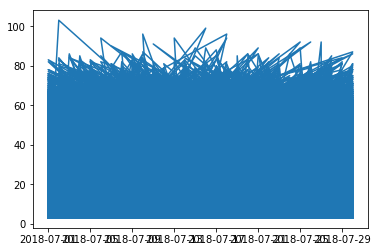

In [129]:
plt.plot(df['TS_D'], df['SAA'])

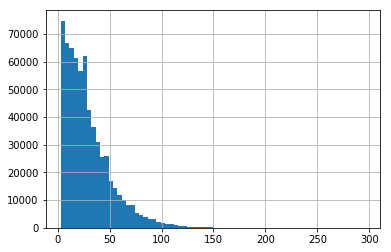

In [81]:
gb3_df['SAA'].hist(bins=70)

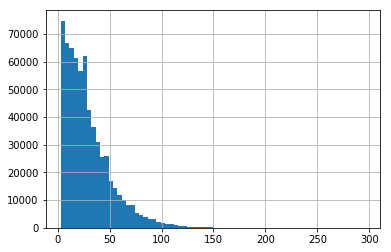

In [82]:
gb3.hist(bins=70)

### Box plot

C:\Users\sds\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


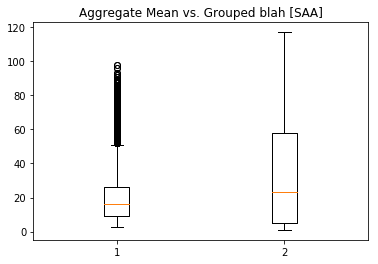

In [103]:
data = [df['SAA'], grouped]
fig1, ax1 = plt.subplots()
ax1.set_title('Aggregate Mean of SAA vs. Grouped blah [SAA]')
ax1.boxplot(data)
plt.show()

C:\Users\sds\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


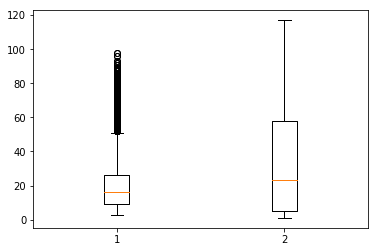

In [104]:
# multiple 
data = [df['SAA'], grouped]
plt.boxplot(data)
plt.show()

{'boxes': [<matplotlib.lines.Line2D at 0x26b38af8390>],
 'caps': [<matplotlib.lines.Line2D at 0x26b38af8da0>,
 'fliers': [<matplotlib.lines.Line2D at 0x26b38b02a58>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x26b38b02630>],
 'whiskers': [<matplotlib.lines.Line2D at 0x26b38af84e0>,
  <matplotlib.lines.Line2D at 0x26b38af8978>]}

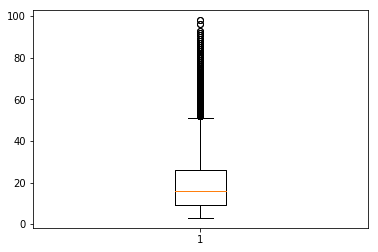

In [90]:
plt.boxplot(df['SAA']) # outlier 가 엄청 많음

{'boxes': [<matplotlib.lines.Line2D at 0x26b38c18080>],
 'caps': [<matplotlib.lines.Line2D at 0x26b38c18a90>,
 'fliers': [<matplotlib.lines.Line2D at 0x26b38c20748>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x26b38c20320>],
 'whiskers': [<matplotlib.lines.Line2D at 0x26b38c181d0>,
  <matplotlib.lines.Line2D at 0x26b38c18668>]}

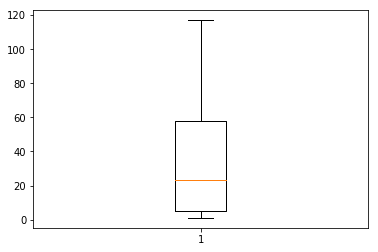

In [94]:
plt.boxplot(grouped)

### df를 sort하기

In [38]:
df.sort_values(by=['MCT_ADM_GDS_APB_CD', 'CLNN'], ascending=True).head()

,CLNN,TS_D,FINAL_CD,SAA,MCT_ADM_GDS_APB_CD,DOF_TF,DAW_CCD,MCT_N,TIME
793510,2,180724,80,8,0,0,2,53,109397
639754,4,180730,3,25,0,0,1,50,129285
160081,6,180701,80,9,0,0,5,81,27187
620289,6,180708,14,19,0,0,4,75,179947
329915,7,180728,92,16,0,0,4,70,239776


### GroupBy 객체를 sorting 하기

In [188]:
# 고객별
grouped = df.groupby(['CLNN'], sort=False).sum() # 여기에서 sort=False 가 중요한 것 같음
grouped.sort_values('SAA', ascending=False)['SAA']  

CLNN
1429.0     2395.0
1310.0     2265.0
2288.0     2224.0
1181.0     2215.0
61.0       2199.0
633.0      2197.0
499.0      2178.0
3008.0     2157.0
2191.0     2124.0
517.0      2110.0
1875.0     2108.0
629.0      2093.0
4892.0     2085.0
2089.0     2084.0
1496.0     2078.0
2147.0     2076.0
1486.0     2071.0
892.0      2065.0
582.0      2058.0
765.0      2053.0
3992.0     2053.0
740.0      2047.0
809.0      2046.0
288.0      2037.0
1013.0     2037.0
497.0      2006.0
2109.0     2005.0
15.0       2002.0
1077.0     1996.0
1373.0     1994.0
            ...  
27803.0       3.0
25893.0       3.0
33069.0       3.0
26775.0       3.0
28345.0       3.0
25193.0       3.0
27212.0       3.0
38607.0       3.0
29240.0       3.0
31011.0       3.0
24959.0       3.0
27235.0       3.0
31458.0       3.0
40288.0       3.0
44074.0       3.0
33343.0       3.0
26854.0       3.0
25104.0       3.0
23492.0       3.0
25860.0       3.0
34295.0       3.0
34917.0       3.0
31731.0       3.0
33882.0       3.0
29269

In [190]:
# 행정동별
grouped = df.groupby(['MCT_ADM_GDS_APB_CD'], sort=False).sum()  
grouped.sort_values('SAA', ascending=False)['SAA']  

MCT_ADM_GDS_APB_CD
4.0      217492.0
6.0      215742.0
8.0      214608.0
13.0     214252.0
3.0      214054.0
5.0      213921.0
11.0     213622.0
7.0      213365.0
9.0      213289.0
15.0     212370.0
2.0      212266.0
1.0      212210.0
12.0     212147.0
18.0     211983.0
17.0     211868.0
16.0     211253.0
10.0     210984.0
14.0     209861.0
19.0     208064.0
22.0     207602.0
20.0     207414.0
21.0     205396.0
25.0     204098.0
24.0     204054.0
23.0     202750.0
28.0     200711.0
27.0     199492.0
32.0     198925.0
26.0     197211.0
29.0     196708.0
           ...   
296.0        58.0
287.0        54.0
291.0        51.0
292.0        51.0
301.0        46.0
345.0        40.0
290.0        38.0
288.0        38.0
298.0        36.0
304.0        35.0
330.0        35.0
289.0        32.0
283.0        32.0
271.0        31.0
286.0        29.0
307.0        28.0
355.0        27.0
294.0        27.0
293.0        26.0
354.0        26.0
295.0        23.0
310.0        18.0
299.0        17.0
313.0    

In [72]:
grouped = df.groupby(['CLNN', 'MCT_ADM_GDS_APB_CD'], sort=False).sum() # 여기에서 sort=False 가 중요 
grouped.sort_values('SAA', ascending=False)['SAA'] # multiple 기준으로 sorting은 안되는듯 

CLNN   MCT_ADM_GDS_APB_CD
735    12                    272
1954   7                     246
3021   7                     244
4157   3                     243
440    10                    239
5117   5                     237
4194   8                     234
1314   25                    233
3584   4                     228
166    7                     228
4758   2                     226
8946   12                    225
462    4                     222
6644   9                     220
1712   16                    220
1686   9                     219
3777   3                     218
6035   4                     215
952    11                    215
2839   7                     214
1136   4                     214
1838   12                    213
5392   16                    212
436    23                    211
1375   16                    211
1761   19                    211
3059   20                    209
2709   9                     207
11723  2                     206
6082   14        

In [ ]:
grouped.sort_values('CLNN', ascending=True) # NOT WORKING !! 처음 group by 한 원래 기준으로 sorting도 안되는듯

In [ ]:
gb2.apply(lambda _df: _df.sort_values(by=['SAA']))

### 조건에 맞는 일부 원소만 추출하기

In [ ]:
cusID = 'Pxxxxxx'
df = df[df.CLNN = cusID]

### Cross-sectional / Aggregate 분석

#### 히스토그램 

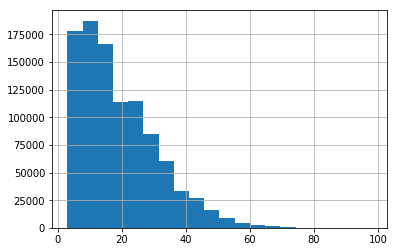

In [42]:
df['SAA'].hist(bins=20)

In [15]:
df['CLNN'].value_counts() 

627.0      113
493.0      110
674.0      107
1769.0     107
204.0      106
608.0      106
2049.0     106
1996.0     105
1495.0     105
654.0      105
3647.0     104
3294.0     104
2213.0     104
1573.0     104
1434.0     104
863.0      104
1229.0     103
1723.0     103
345.0      103
11.0       103
2415.0     102
2003.0     102
559.0      102
669.0      102
2217.0     102
93.0       102
409.0      102
1889.0     102
804.0      101
1397.0     101
          ... 
26396.0      1
30593.0      1
30060.0      1
26392.0      1
30561.0      1
29980.0      1
26608.0      1
29976.0      1
37116.0      1
30590.0      1
30024.0      1
30633.0      1
30618.0      1
31284.0      1
30630.0      1
31244.0      1
31232.0      1
30036.0      1
31236.0      1
30619.0      1
26528.0      1
30597.0      1
30044.0      1
30614.0      1
30613.0      1
30609.0      1
30020.0      1
30605.0      1
30601.0      1
32767.0      1
Name: CLNN, Length: 31284, dtype: int64

value_counts 함수를 이용해 자동으로 그루핑되어 sum up된 결과물을 볼 수 있다.

In [ ]:
분포

### 시계열 분석 

1. 7월 1일부터 9월 30일까지의 총 매출 건수 추이 -- 원래 YoY, MoM 들어가야 하지만...
2. 7월 1일부터 9월 30일까지의 총 매출 금액 추이
3. 7월 1일부터 9월 30일까지의 매출 건수/인 추이
4. 7월 1일부터 9월 30일까지의 매출 금액/인 추이
5. 7월 1일부터 9월 30일까지의 행정동 개수/인 추이 -- mobility 의 지표, 향후 거리 개념이 도입되면 평균 이동거리를 알 수 있음 
6. ....

### 공간 시계열 분석

 (매출 상위 100개 행정동)

log('SAA')

20-
15-
10-
05-
00- ----------------------------
    z0 z1 z3 z4 ....................
    
zone 별 매출 share가 이미 다르다 --> 상권의 비동질성
집중도.......
주식시장, 자산시장, 

시간대별 매출 분포 -- 이건 지역별로 너무 다를 듯

log('SAA')

20-
15-
10-
05-
00- ---------------------
    00 04 08 12 16 20 24 

https://financedata.github.io/posts/python_starbucks_map.html
지리정보

In [ ]:
인별 점찍기....

시간
24-
20-
16-
12-
08-
04-
00- ----------------------------
    z0 z1 z3 z4 ....................

In [ ]:
인별 feature -- 거래건의 최신성이나 금액에 있어 가중치는 0

시간: round('TIME'/240000) -- 아침러 vs 저녁러 -- 소비시간 score ..... 0시는 삭제하거나 하루의 시작을 +6 으로 하거나
요일: 
장소: 평균 19개 --> len(['FINAL_CD'])/19 
업종

시간 집중도
장소 집중도
업종 집중도

### 문자열을 숫자로 type 바꾸기

http://m.dbguide.net/about.db?cmd=view&boardConfigUid=19&boardUid=188976

In [ ]:
levels = []
for level in deck:
    levels.append(level[0])

첫 번째 글자만 가져와서 새로운 객체에 담아보자. 
새로운 리스트 객체 levels에 앞 글자 하나만 가져와서 담은 후에 이를 아래와 같이 DataFrame으로 만들어보자.

In [ ]:
cabin_df = DataFrame(levels)
cabin_df.columns = ['Cabin']
cabin_df.head()

T라는 Deck는 없는데 그래프에는 T라는 데이터가 있다는 것이다. T라는 Deck만 빼고 다시 가져와야 한다.

In [ ]:
cabin_df = cabin_df[cabin_df.Cabin != 'T']
sns.factorplot('Cabin', kind='count', data=cabin_df, palette='summer')

DataFrame인 titanic_df의 각 컬럼에 접근하는 것의 기준은 점(.)이다. 
Survived 컬럼에서 map이라는 함수를 이용해 특정 정보일 경우, 특정 값으로 매핑을 해준 것이다. 

In [ ]:
titanic_df["Survivor"] = titanic_df.Survived.map({0: "no", 1: "yes"})

DataFrame인 titanic_df의 각 컬럼에 접근하는 것의 기준은 점(.)이다. 
xSurvived 컬럼에서 map이라는 함수를 이용해 특정 정보일 경우, 특정 값으로 매핑을 해준 것이다. 

DataFrame인 titanic_df의 각 컬럼에 접근하는 것의 기준은 점(.)이다. 
Survived 컬럼에서 map이라는 함수를 이용해 특정 정보일 경우, 특정 값으로 매핑을 해준 것이다. 

### 시간정보를 파싱하기

문자열로부터 날짜와 시간 정보를 읽어서 datetime.datetime 클래스 객체를 만들 수도 있다. 이 때는 datetime.datetime.strptime() 클래스 메서드를 사용한다. 첫 번째 인수로는 날짜와 시간 정보를 가진 문자열을, 두번째 인수로는 그 문자열을 해독할 수 있는 형식 문자열을 넣는다.

In [164]:
datetime.datetime.strptime("2017-01-02 14:44", "%Y-%m-%d %H:%M")

datetime.datetime(2017, 1, 2, 14, 44)

In [166]:
datetime.datetime.strptime("144401", "%H%M%S")

datetime.datetime(1900, 1, 1, 14, 44, 1)

*이슈사항 1: Resolve type problem*

In [43]:
# float을 integer로 바꾸기 !!!! 
df['TS_D'] = df.TS_D.astype(int) 

In [33]:
# integer를 datetime으로 바꾸기
# Working
df['TS_D'] = pd.to_datetime(df['TS_D'], format='%y%m%d') # %Y는 4글자 연도 

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
CLNN                  1000000 non-null float64
TS_D                  1000000 non-null datetime64[ns]
FINAL_CD              1000000 non-null float64
SAA                   1000000 non-null float64
MCT_ADM_GDS_APB_CD    1000000 non-null float64
DOF_TF                1000000 non-null float64
DAW_CCD               1000000 non-null float64
MCT_N                 1000000 non-null float64
TIME                  1000000 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 68.7 MB


In [41]:
# NOT Working 
datetime.datetime.strptime(df['TIME'], "%H%M%S")
# gets Warning Message: triptime() arguement 1 must be str, not Series*.

In [42]:
# NOT Working
df['DATE'] = df['TS_D'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d'))

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
CLNN                  1000000 non-null float64
TS_D                  1000000 non-null datetime64[ns]
FINAL_CD              1000000 non-null float64
SAA                   1000000 non-null float64
MCT_ADM_GDS_APB_CD    1000000 non-null float64
DOF_TF                1000000 non-null float64
DAW_CCD               1000000 non-null float64
MCT_N                 1000000 non-null float64
TIME                  1000000 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 68.7 MB


In [25]:
# 이슈사항 2: ==> resolved

In [26]:
# 이슈사항 3: is null을 물었을 때 True의 개수 확인* ==> resolved

In [6]:
# 숫자로 바꿀 수 없는 문자열이 있는지 확인 => resolved

In [27]:
# 이슈사항4: df를 합칠 때 컬럼이 다른 경우 => resolved*

*이슈사항5: 시간을 불러와서 시간별로 합치거나, 시간의 계산을 하려고 한다*

http://enjoyiot.tistory.com/category/Python/04_Pandas%EB%A5%BC%20%ED%86%B5%ED%95%9C%20%EC%8B%9C%EA%B3%84%EC%97%B4%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%28Time%20Series%29%20%EC%B2%98%EB%A6%AC

In [27]:
# 그 전에 인덱스를 날짜로 바꾸어 주어야 함 # 방법 (1)
df_t = pd.read_csv('df.csv', index_col='TS_D', parse_dates=True)

In [11]:
df_t.head()

,Unnamed: 0,CLNN,FINAL_CD,SAA,MCT_ADM_GDS_APB_CD,DOF_TF,DAW_CCD,MCT_N,TIME
TS_D,,,,,,,,,
2018-07-19,0,14437,25,11,26,0,5,36,199982
2018-07-09,1,2414,10,7,35,0,0,88,57272
2018-07-28,2,2136,82,9,2,0,2,83,135636
2018-07-13,3,15588,72,16,21,1,1,60,156460
2018-07-28,4,6377,37,14,31,0,2,58,2430


In [36]:
# 그 전에 인덱스를 날짜로 바꾸어 주어야 함 # 방법 (2)
df.set_index('TS_D', inplace=False)

,CLNN,FINAL_CD,SAA,MCT_ADM_GDS_APB_CD,DOF_TF,DAW_CCD,MCT_N,TIME
TS_D,,,,,,,,
2018-07-04,2371.0,10.0,13.0,37.0,1.0,0.0,2.0,197937.0
2018-07-14,7983.0,39.0,16.0,50.0,0.0,3.0,85.0,48545.0
2018-07-12,12109.0,38.0,35.0,75.0,1.0,0.0,72.0,157611.0
2018-07-15,2615.0,19.0,4.0,0.0,0.0,3.0,23.0,21276.0
2018-07-01,7652.0,24.0,27.0,27.0,1.0,4.0,36.0,41395.0
2018-07-16,5637.0,49.0,8.0,68.0,0.0,0.0,56.0,154741.0
2018-07-18,10277.0,76.0,37.0,7.0,0.0,4.0,25.0,157305.0
2018-07-09,6473.0,18.0,30.0,1.0,0.0,1.0,52.0,42999.0
2018-07-22,9432.0,59.0,25.0,43.0,1.0,5.0,30.0,207550.0


In [28]:
df_t.index

DatetimeIndex(['2018-07-19', '2018-07-09', '2018-07-28', '2018-07-13',
               '2018-07-28', '2018-07-05', '2018-07-14', '2018-07-18',
               '2018-07-14', '2018-07-11',
               ...
               '2018-07-16', '2018-07-12', '2018-07-09', '2018-07-24',
               '2018-07-06', '2018-07-08', '2018-07-05', '2018-07-22',
               '2018-07-16', '2018-07-25'],
              dtype='datetime64[ns]', name='TS_D', length=1000000, freq=None)

In [110]:
gb01 = df_t.groupby(['CLNN', 'TS_D']).sum()

In [45]:
gb01['SAA'].head()

CLNN  TS_D      
0     2018-07-01    12
      2018-07-03    11
      2018-07-04    23
      2018-07-05    95
      2018-07-06    41
Name: SAA, dtype: int64

In [111]:
gb01.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 479463 entries, (0, 2018-07-01 00:00:00) to (52504, 2018-07-22 00:00:00)
Data columns (total 8 columns):
Unnamed: 0            479463 non-null int64
FINAL_CD              479463 non-null int64
SAA                   479463 non-null int64
MCT_ADM_GDS_APB_CD    479463 non-null int64
DOF_TF                479463 non-null int64
DAW_CCD               479463 non-null int64
MCT_N                 479463 non-null int64
TIME                  479463 non-null int64
dtypes: int64(8)
memory usage: 30.9 MB


In [102]:
gb01.pivot(index='CLNN', columns='TS_D', values='SAA')

KeyError: 'CLNN'

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
Unnamed: 0            1000000 non-null int64
CLNN                  1000000 non-null int64
TS_D                  1000000 non-null object
FINAL_CD              1000000 non-null int64
SAA                   1000000 non-null int64
MCT_ADM_GDS_APB_CD    1000000 non-null int64
DOF_TF                1000000 non-null int64
DAW_CCD               1000000 non-null int64
MCT_N                 1000000 non-null int64
TIME                  1000000 non-null int64
dtypes: int64(9), object(1)
memory usage: 76.3+ MB


In [104]:
gb02 = df.groupby['CLNN', 'MCT_ADM_GDS_APB_CD', 'FINAL_CD']

TypeError: 'method' object is not subscriptable

In [50]:
df_t.resample(rule='W').max()  #? 무엇을 max 로 보았다는 뜻인지.... # 각 컬럼 내에서 그 시간 기준별로 max

,Unnamed: 0,CLNN,FINAL_CD,SAA,MCT_ADM_GDS_APB_CD,DOF_TF,DAW_CCD,MCT_N,TIME
TS_D,,,,,,,,,
2018-07-01,999986,44622,99,83,113,1,5,99,239989
2018-07-08,999996,47645,99,103,149,1,5,99,239999
2018-07-15,999992,47954,99,96,143,1,5,99,239999
2018-07-22,999998,52504,99,99,149,1,5,99,239998
2018-07-29,999999,46181,99,92,134,1,5,99,239999
2018-08-05,999980,44182,99,87,135,1,5,99,239988


In [40]:
df_weekly_sum = df_t.resample(rule='W').sum()

In [38]:
df_weekly_sum.head()['SAA']

TS_D
2018-07-01     627320
2018-07-08    4428541
2018-07-15    4443135
2018-07-22    4403182
2018-07-29    4418027
Freq: W-SUN, Name: SAA, dtype: int64

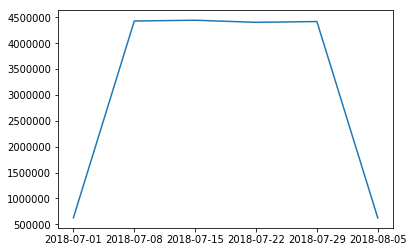

In [42]:
plt.plot(df_weekly_sum['SAA'])

In [61]:
from bokeh.plotting import *
from bokeh.models import HoverTool
from collections import OrderedDict

In [22]:
print(plt.rcParams['agg.path.chunksize']) # 오류 발생하여 matplotlib의 파라미터 증가시킴
plt.rcParams['agg.path.chunksize'] = 10000

0


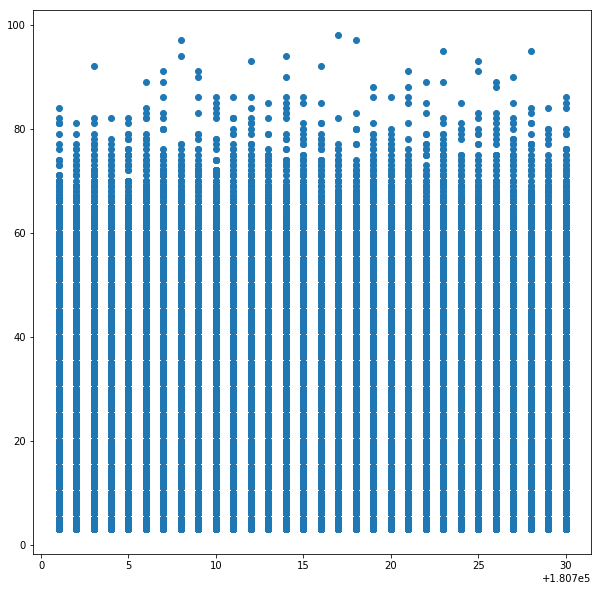

In [24]:
plt.figure(figsize=(10, 10))
plt.scatter(df['TS_D'], df['SAA'])

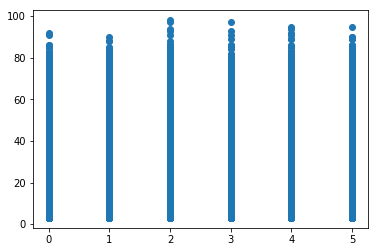

In [29]:
plt.scatter(df['DAW_CCD'], df['SAA'])

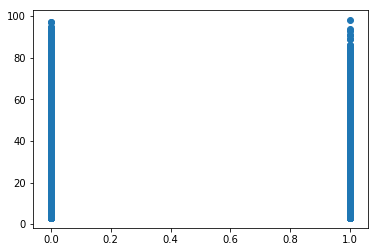

In [30]:
plt.scatter(df['DOF_TF'], df['SAA'])

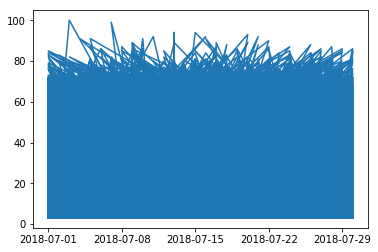

In [20]:
plt.plot(df['TS_D'], df['SAA'])

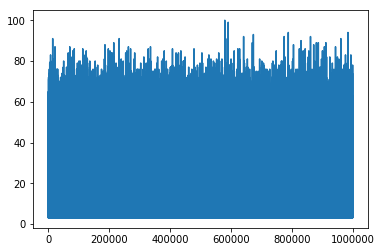

In [28]:
plt.plot(df['SAA'], '-')

In [ ]:
plt.plot([10, 20, 30, 40], [1, 4, 9, 16], 'rs--')

In [27]:
# data = df.pivot(index='TS_D', columns='DAW_CCD', values='SAA')

# # Index contains duplicate entries, cannot reshape

In [ ]:
# customized function

def first_day(entry):
    return entry[0]

df.resample('A').apply(first_day)

In [ ]:
# 각 close에 대해 매년 평균 구하고 bar 차트를 그려라
df['Close'].resample('A').mean().plot(kind='bar') 
df['Close'].resample('M').mean().plot(kind='bar', figsize=(16, 6))

DateTime Index
Time Resampling
Time Shifts
Rolling and Expanding

dataframe의 행 또는 열 삭제하기

In [ ]:
# 열 삭제
df = df.drop('col_name', 1) # 여기서 1은 축 번호, 행은 0, 열은 1

# 혹은 df를 재할당하지 않고 열 삭제
df.drop('col_name', axis=1, inplace=True)

# 열 레이블 대신 열 번호를 사용하여 삭제
df.drop(df.columns[[0, 1, 3]], axis=1)

### Join Data

### 다른 df로부터 정보 추출하여 매칭하기

In [ ]:
# 먼저 CLNN 과 주 소비지역(행정동)으로 aggregate 후 고객 demo정보 매칭
# 먼저 CLNN 과 주 소비시간(시간)으로 aggregate 후 demo정보 매칭
# 먼저 CLNN 과 주 업종? 으로 aggregate 후 demo정보 매칭

In [130]:
# upjong

num_upjong = 2786049
upjong = pd.DataFrame(np.random.randint(0, 100, size=(num_upjong, 3)))
upjong.columns = ['MCT_N', 'FINAL_CD', 'FINAL_CD_NM']
upjong.head()

# MCT_N: 가맹점 번호(문자)
# FINAL_CD: 업종 코드(숫자)
# FINAL_CD_NM: 업종 코드 명(문자)

,MCT_N,FINAL_CD,FINAL_CD_NM
0,63,24,12
1,57,24,12
2,95,66,11
3,58,79,4
4,73,70,96


In [ ]:
# demo

# CLNN (문자)
# SEX_CCD: M:남성 F:여성 (문자)
# CLN_AGE: 숫자
# AGE_GB (나이그룹핑) (총 5그룹) (문자) 
# - 01_25세이하
# - 02_26-30세
# - 03_31-40세
# - 04_41_60세
# - 05_61세 이상
# HOME_HJ_CD: 고객 집주소 행정동 코드(null값 가능)
# JOB_HJ_CD: 고객 직장주소 행정동 코드(null값 가능)


In [144]:
# 행정동 코드 정보

hj = pd.DataFrame(np.random.randint(0, 423, size=(4000, 2)))
hj.columns = ['HJ_CD', 'HJ_CD_NM']

import random
import string
hjd = random.choice(string.ascii_letters)

# WID_CTY_CD: 광역도시 코드(문자)
# GDS_CTY_CD: GDS시군구코드(문자)
# GDS_BRG_CD: GDS구군코드(문자)
# ADM_GDS_VLG_CD: 행정GDS읍면동 코드(문자)
# HJ_CD: 행정동코드(광역도시코드||GDS시군구코드||DS구군코드||행정GDS읍면동 코드) (문자) * 가맹점/고객행정동 코드와 조인 가능 
# GDS_WID_TRL_NM: 광역도시코드명(문자) * 11: 서울
# GDS_DSR_NM: 시군구코드명 (문자)
# GDS_OL_DM: 구군코드명(문자)
# HJ_CD_NM: 시군구코드명||행정읍면동 코드명(문자) * HG_CD에 해당하는 코드명으로 향후 행정동명 세팅시 본 컬럼 이용 가능

In [161]:
def randchar(a, b):
    return chr(random.randint(ord(a), ord(b)))
randchar(a, b)

NameError: name 'a' is not defined

In [152]:
np.array(random_char(30))

array('hSfTjKJcIDqAqKbyVjXtoadYRFwLJc', dtype='<U30')

In [131]:
# Join df_agg and 행정동

df_agg 


필요로 하는 집계함수가 pandas GroupBy methods에 없는 경우 사용자 정의 함수를 정의해서 집계에 사용할 수 있습니다. IQR(Inter-Quartile Range, Q3 - Q1) 를 사용자 정의 함수로 정의하고, 이를 grouped.aggregate() 혹은 grouped.agg() 의 괄호 안에 넣어서 그룹 별로 IQR를 계산해보겠습니다. 

In [ ]:
def iqr_func(x):

    q3, q1 = np.percentile(x, [75, 25])

    iqr = q3 - q1

    return iqr

In [ ]:
groupedByDong.agg(iqr_func) # groupedByDong.aggregate(iqr_func) 도 같은 결과